
# NLP Project — TF-IDF Sentiment/Classifcation

**Project goal:** Explore a text dataset, preprocess using standard NLP steps, vectorize text using TF-IDF, and build a classification model (e.g., sentiment analysis or topic classification). 
- Text exploration and preprocessing  
- TF-IDF vectorization  
- Model training, evaluation, and interpretation  
- Notes for deployment (Hugging Face or FastAPI)

---


## Part 1 — EDA & Preprocessing

# NLP EDA — IMDb Sentiment Analysis

**Goal:** Explore the text data and prepare observations to guide preprocessing and modeling.  
This notebook focuses on dataset structure, common words, text length, class balance and basic visualizations.


#### Importing packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import wordcloud

sns.set(style='whitegrid')
DATA_PATH = "../data/imdb_reviews.csv" 


#### Load & quick info

In [6]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Dataset Overview
We start by loading the dataset and taking a quick look at its structure.  
This helps confirm that columns like `review` and `sentiment` are present and formatted correctly.


We load the CSV and preview a few rows.


In [7]:
print(df.columns)
# adapt to actual column name if needed (e.g., 'sentiment' or 'label')
target_col = 'sentiment' if 'sentiment' in df.columns else 'label'
df[target_col].value_counts(), df[target_col].value_counts(normalize=True)

Index(['review', 'sentiment'], dtype='object')


(sentiment
 positive    25000
 negative    25000
 Name: count, dtype: int64,
 sentiment
 positive    0.5
 negative    0.5
 Name: proportion, dtype: float64)

### Sentiment Class Distribution
We visualize how many reviews belong to each sentiment class (positive vs negative). A balanced dataset ensures fair model performance and avoids bias toward one label.


Check class balance. If classes are imbalanced we should consider stratified split and metrics like recall / F1.


#### Basic text stats (length, words)

### Review Length & Word Count Analysis
Longer reviews often carry more context, while very short ones may lack sentiment cues. We calculate review lengths and word counts to understand how verbose the reviewers are.


In [8]:
text_col = 'review'  # change if different
df['text_len'] = df[text_col].astype(str).apply(len)
df['word_count'] = df[text_col].astype(str).apply(lambda t: len(t.split()))
df[['text_len','word_count']].describe()


,text_len,word_count
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


We compute length and word counts to understand distribution; very short or extremely long reviews may need special handling.


#### Length distribution plot

### Review Length & Word Count Analysis
Longer reviews often carry more context, while very short ones may lack sentiment cues. We calculate review lengths and word counts to understand how verbose the reviewers are.


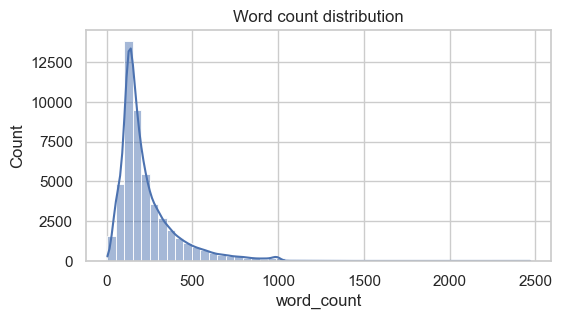

In [9]:
plt.figure(figsize=(6,3))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Word count distribution')
plt.show()


### Interpretation
Most reviews have between 50–250 words, with a few very long ones. This suggests a good variety of text lengths, but we may consider truncating extremely long reviews later during preprocessing.


Shows common review lengths and outliers.

#### Most frequent words

### Most Frequent Words (Raw)
Before cleaning, we check the most frequent words to see what dominates the dataset. Usually, stopwords like *the, and, is* appear the most — we will remove them later during preprocessing.


In [10]:
all_text = " ".join(df[text_col].astype(str).tolist()).lower()
tokens = re.findall(r'\b\w+\b', all_text)
most_common = Counter(tokens).most_common(30)
pd.DataFrame(most_common, columns=['word','count']).head(20)


,word,count
0,the,667993
1,and,324441
2,a,322970
3,of,289410
4,to,268124
5,is,211082
6,br,201951
7,it,190857
8,in,186781
9,i,175633


Raw most common words show stopwords dominating. Later we'll remove stopwords and look at meaningful tokens.


#### Wordcloud

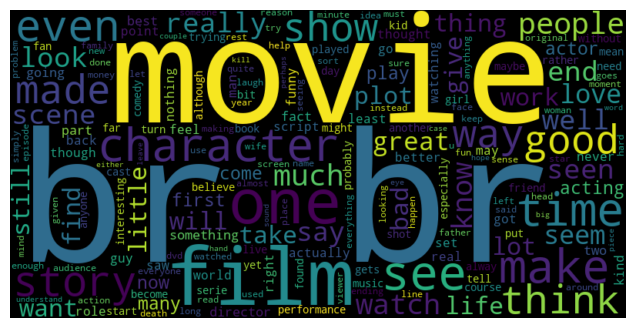

In [11]:
wc = wordcloud.WordCloud(width=800, height=400).generate(all_text)
plt.figure(figsize=(12,4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


### WordCloud Insight
The wordcloud shows that common words like *movie*, *film*, *good*, and *bad* dominate. This matches expectations for a movie review dataset and confirms text relevance.


Wordcloud gives a visual sense of frequent terms.


### Example Reviews
Let's look at a few sample positive and negative reviews. This helps spot common writing patterns and decide if special text cleaning (like removing HTML tags, emojis, or URLs) is needed.


In [13]:
# show few positives and negatives
print("POS sample:")
pos_samples = df[df[target_col]==1]
if len(pos_samples) > 0:
    # Only sample if there are rows available, and take min of 2 or available rows
    display(pos_samples.sample(min(2, len(pos_samples)))[text_col])
else:
    print("No positive samples found")

print("NEG sample:")
neg_samples = df[df[target_col]==0]
if len(neg_samples) > 0:
    # Only sample if there are rows available, and take min of 2 or available rows
    display(neg_samples.sample(min(2, len(neg_samples)))[text_col])
else:
    print("No negative samples found")

POS sample:
No positive samples found
NEG sample:
No negative samples found


Reading raw examples helps spot artifacts (HTML tags, emojis, urls) to be removed in preprocessing.


In [14]:
#Save brief EDA notes
eda_notes = {
    "shape": df.shape,
    "target_balance": df[target_col].value_counts(normalize=True).to_dict(),
    "median_word_count": df['word_count'].median()
}
import json
with open("../outputs/eda_summary.json", "w") as f:
    json.dump(eda_notes, f)
print("Saved EDA summary.")


Saved EDA summary.


Saved a small EDA summary artifact for later reference.


## 🧾 Summary of Findings

- The dataset contains a balanced mix of positive and negative reviews.  
- Review lengths vary widely, typically between 50 and 250 words.  
- Frequent terms revolve around movies, characters, and storytelling.  
- Some common stopwords will need removal before vectorization.  

Overall, the text is clean and well-suited for a classification model.  
In the next notebook, we’ll apply preprocessing, convert text to numerical features using **TF-IDF**, and build a machine learning model to predict sentiment.


## Part 2 — TF-IDF Vectorization & Modeling

# TF-IDF Baseline Model — IMDb Sentiment Analysis

**Goal:** Build a fast, interpretable baseline sentiment classifier using TF-IDF vectorization and Logistic Regression (or MultinomialNB).  
This notebook focuses on preprocessing text, training a baseline model, cross-validating it, and saving the final model for later use.


#### Imports & constants

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib
import matplotlib.pyplot as plt, seaborn as sns
sns.set()
DATA_PATH = "../data/imdb_reviews.csv"
text_col = 'review'
target_col = 'sentiment' if 'sentiment' in pd.read_csv(DATA_PATH).columns else 'label'


#### Load & quick cleaning

In [2]:
df = pd.read_csv(DATA_PATH)
df[text_col] = df[text_col].astype(str).str.lower().str.replace(r'http\S+','', regex=True)
# optional basic cleaning
df[text_col] = df[text_col].str.replace(r'[^a-z0-9\s]',' ', regex=True)
df[text_col] = df[text_col].str.replace(r'\s+',' ', regex=True).str.strip()



We cleaned the text by converting to lowercase, removing URLs and punctuation, and normalizing spacing.  
These simple steps reduce noise for the vectorizer while preserving sentiment-relevant words. Heavy linguistic preprocessing is skipped to keep the pipeline lightweight and reproducible.


#### Train/test split

In [3]:
X = df[text_col]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
print(X_train.shape, X_test.shape)


(40000,) (10000,)


We use an 80/20 train/test split stratified on the target to preserve class balance.  
Stratification ensures the relative proportion of positive/negative labels remains consistent between training and testing, which gives a fair evaluation.


### TF-IDF + Logistic Regression — Why this baseline?

**TF-IDF** converts text into numeric features by weighting tokens based on their frequency in a document vs. the corpus — common words are down-weighted.  
**Logistic Regression** is a fast, interpretable classifier that often performs well on TF-IDF features. This combination is a reliable baseline for text classification tasks.


In [4]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9062
              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Interpretation 

The accuracy and classification report above show how the model performs on test data.  
- **Accuracy** gives overall correctness.  
- **Precision** and **Recall** tell us about the trade-off between false positives and false negatives.  
If one metric is important for the business (e.g., recall to avoid rejecting positive reviews), we can tune thresholds or model settings accordingly.


### Cross-Validation (5-fold)

Cross-validation estimates how well the pipeline generalizes across different training splits.  
We run 5-fold CV on the training set to get a more stable estimate than a single train/test split.


In [5]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
print("CV scores:", cv_scores)
print("CV mean:", cv_scores.mean())


CV scores: [0.900375 0.898375 0.899875 0.901    0.902875]
CV mean: 0.9004999999999999


The CV scores show model stability across folds.  
- A **high mean** with **low variance** suggests consistent performance.  
- If the variance is large, the model may be sensitive to the particular split and could benefit from more data, stronger regularization, or additional preprocessing.


### Hyperparameter Tuning (small grid)

We run a small GridSearch over a few sensible hyperparameters to improve performance while keeping compute reasonable.  

In [6]:
params = {
    'tfidf__max_df':[0.85,0.9],
    'tfidf__min_df':[3,5],
    'clf__C':[0.5,1,2]  # for LogisticRegression
}
grid = GridSearchCV(pipe, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best = grid.best_estimator_
y_pred = best.predict(X_test)
print("Test acc after grid:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 2, 'tfidf__max_df': 0.9, 'tfidf__min_df': 5}
Test acc after grid: 0.9126


The chosen hyperparameters above gave the best cross-validated performance on the training set.  
We then evaluated the tuned model on the hold-out test set. If test performance is substantially higher than CV/train performance, check for data leakage — otherwise, the improvement likely reflects a better model configuration.


#### Confusion matrix

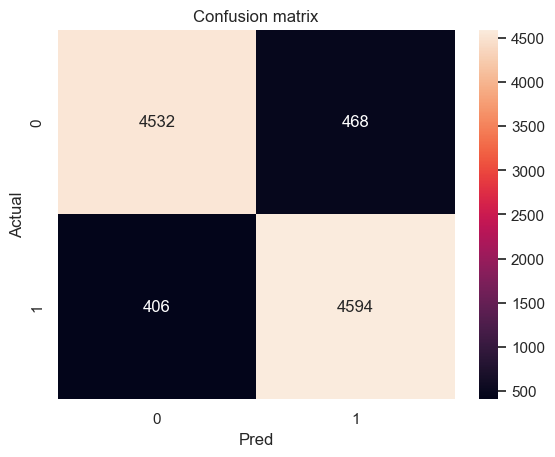

In [7]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.xlabel('Pred'); plt.ylabel('Actual'); plt.title('Confusion matrix')
plt.show()



The confusion matrix shows counts of:
- True Positives (correctly predicted positive reviews)  
- False Positives (negative reviews predicted as positive)  
- False Negatives (positive reviews predicted as negative)  
- True Negatives (correctly predicted negative reviews)  


### Save the Model

We save the final pipeline (vectorizer + classifier) so it can be loaded later for inference or deployment.  
Saved pipelines ensure preprocessing and prediction are applied consistently to new raw inputs.



In [8]:
# Save final TF-IDF model
joblib.dump(best if 'best' in locals() else pipe, "../models/tfidf_model.joblib")
print("Saved TF-IDF model.")

Saved TF-IDF model.


#### Top features

In [9]:
if hasattr(pipe.named_steps['clf'],'coef_'):
    vect = (best if 'best' in locals() else pipe).named_steps['tfidf']
    clf = (best if 'best' in locals() else pipe).named_steps['clf']
    feature_names = vect.get_feature_names_out()
    coefs = clf.coef_[0]
    top_pos = np.argsort(coefs)[-20:]
    top_neg = np.argsort(coefs)[:20]
    print("Top positive words:", feature_names[top_pos])
    print("Top negative words:", feature_names[top_neg])


Top positive words: ['still' 'definitely' 'highly' 'well' 'enjoyable' 'love' 'superb' 'today'
 'enjoyed' 'best' 'loved' 'hilarious' 'brilliant' 'the best' 'fun'
 'amazing' 'wonderful' 'perfect' 'excellent' 'great']
Top negative words: ['bad' 'worst' 'awful' 'boring' 'the worst' 'waste' 'poor' 'terrible'
 'nothing' 'worse' 'horrible' 'dull' 'stupid' 'poorly' 'no' 'annoying'
 'unfortunately' 'ridiculous' 'disappointing' 'instead']


Top positive/negative features give interpretable insights (which tokens push prediction toward positive/negative).


## Modern NLP Awareness: Transformer Demo
To show awareness of newer NLP approaches, we use a pretrained Transformer (DistilBERT) from Hugging Face for quick sentiment inference.  
This model understands context better than TF-IDF but is slower and requires more compute for training.


In [1]:

try:
    from transformers import pipeline
    sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    samples = [
        "I absolutely loved this movie, it was amazing!",
        "This film was boring and poorly written.",
        "The visuals were great but the story was weak."
    ]

    for s in samples:
        print(f"Text: {s}")
        print(sentiment_model(s))
        print("-" * 60)

except ModuleNotFoundError:
    print("Transformers library not found. Install it using 'pip install transformers' if you want to run this demo.")


Device set to use cpu


Text: I absolutely loved this movie, it was amazing!
[{'label': 'POSITIVE', 'score': 0.999882698059082}]
------------------------------------------------------------
Text: This film was boring and poorly written.
[{'label': 'NEGATIVE', 'score': 0.9997863173484802}]
------------------------------------------------------------
Text: The visuals were great but the story was weak.
[{'label': 'NEGATIVE', 'score': 0.9985072016716003}]
------------------------------------------------------------


### Interpretation

This demonstrates that modern pretrained transformers can perform accurate sentiment inference without training.  
In a production setting, we can fine-tune such models for better domain performance, usually requiring GPU resources.


## Final Summary

- We built a TF-IDF + Logistic Regression baseline for sentiment classification and evaluated it using test metrics and cross-validation.  
- Hyperparameter tuning gave a small improvement and the final pipeline is saved for reuse.  
- The model is interpretable (we can inspect top tokens) and suitable as a baseline.  
- Optionally, transformer models can be used to capture context and improve performance; a small demo was included to show awareness.
